# Setup

In [3]:
using WAV
include("../tools/plotting.jl");
include("../model/model.jl");
include("../model/gammatonegram.jl");
include("../model/time_helpers.jl");

In [4]:
source_params, steps, gtg_params, obs_noise = include("../params/base.jl")
sr = 2000.0
gtg_params["dB_threshold"] = 0.0
wts, = gtg_weights(sr, gtg_params);

# Model

### Embed a sound within a larger scene

In [5]:
# sr, onset
function embed_in_scene(scene_length, sr, wave, onset)
  n_samples = Int(floor(sr * scene_length))
  scene_wave = zeros(n_samples)
  sample_start = max(1, Int(floor(onset * sr)))
  sample_finish = min(sample_start + length(wave), length(scene_wave))
  scene_wave[sample_start:sample_finish-1] = wave[1:length(sample_start:sample_finish-1)]
  return scene_wave
end

embed_in_scene (generic function with 1 method)

### Generate white noise sound

In [6]:
# get_gp_spectrotemporal, generate_noise

@gen function generate_single_noise(scene_length, steps, sr)
  onset ~ uniform(0, scene_length)
  duration ~ uniform(0.1, 1.0)
  amp ~ normal(10.0, 8.0)
  times, t, f = get_gp_spectrotemporal([onset, onset+duration], steps, sr)
  noise_wave = generate_noise(transpose(reshape(fill(amp, length(times)), (length(f), length(t)))), duration, steps, sr, 1e-6)
  return embed_in_scene(scene_length, sr, noise_wave, onset)
end;

### Generate tone with pitch

In [7]:
@gen function generate_single_tone(scene_length, step_size, sr)
  step_size = step_size["t"]
  erb ~ uniform(0.4, 37.0)
  onset ~ uniform(0.0, scene_length)
  duration ~ uniform(0.1, 1.0)
  times = get_element_gp_times([onset, onset + duration], step_size)
  wave = generate_tone(fill(erb, length(times)), fill(50.0, length(times)), duration, step_size, sr, 1.0e-6)
  return embed_in_scene(scene_length, sr, wave, onset)
end;

### Generate sound (noise or tone)

In [8]:
@gen function generate_single_sound(scene_length, steps, sr)
    is_noise ~ bernoulli(0.4)
    if is_noise
        wave = {*} ~ generate_single_noise(scene_length, steps, sr)
    else
        wave = {*} ~ generate_single_tone(scene_length, steps, sr)
    end
    return wave
end
generate_sounds = Map(generate_single_sound);

### Generate scene with many sounds

In [9]:
@gen (static) function generate_scene(scene_duration, wts, audio_sr, steps, gtg_params)
  n_tones ~ uniform_discrete(1, 4)
  waves ~ generate_sounds(fill(scene_duration, n_tones), fill(steps, n_tones), fill(audio_sr, n_tones))
  n_samples = Int(floor(scene_duration * audio_sr))
  scene_wave = reduce(+, waves; init=zeros(n_samples))
  scene_gram, = gammatonegram(scene_wave, wts, audio_sr, gtg_params)
  scene ~ noisy_matrix(scene_gram, 1.0)
  return scene_gram, scene_wave, waves
end;

In [10]:
@load_generated_functions

# Trace visualization and playback

In [85]:
function plot_waveform(waveform, duration)
    times = range(0.0, duration, length=length(waveform))
    plot(times, waveform, linewidth=0.1)
    xlabel("Time (seconds)")
    yticks([])
end

plot_waveform (generic function with 2 methods)

In [170]:
function vis_and_write_wave(tr, title; tspan=nothing)
  duration, _, sr, = get_args(tr)
  gram, scene_wave, = get_retval(tr)
  wavwrite(scene_wave/maximum(abs.(scene_wave)), title, Fs=sr)

figure(dpi=400)
    subplot(2, 1, 1)
  plot_waveform(scene_wave, duration)
    if tspan != nothing
        gca().set_xlim(tspan)
    end
    subplot(2, 1, 2)
  plot_gtg(gram, duration, sr, 0, 100, plot_colorbar=false)
        if tspan != nothing
        gca().set_xlim(tspan)
    end
    tight_layout()
    savefig("$title.png")
end

vis_and_write_wave (generic function with 1 method)

Some default arguments to `generate_scene`:

In [171]:
args = (2.0, wts, sr, steps, gtg_params);

Generate and visualize a trace:

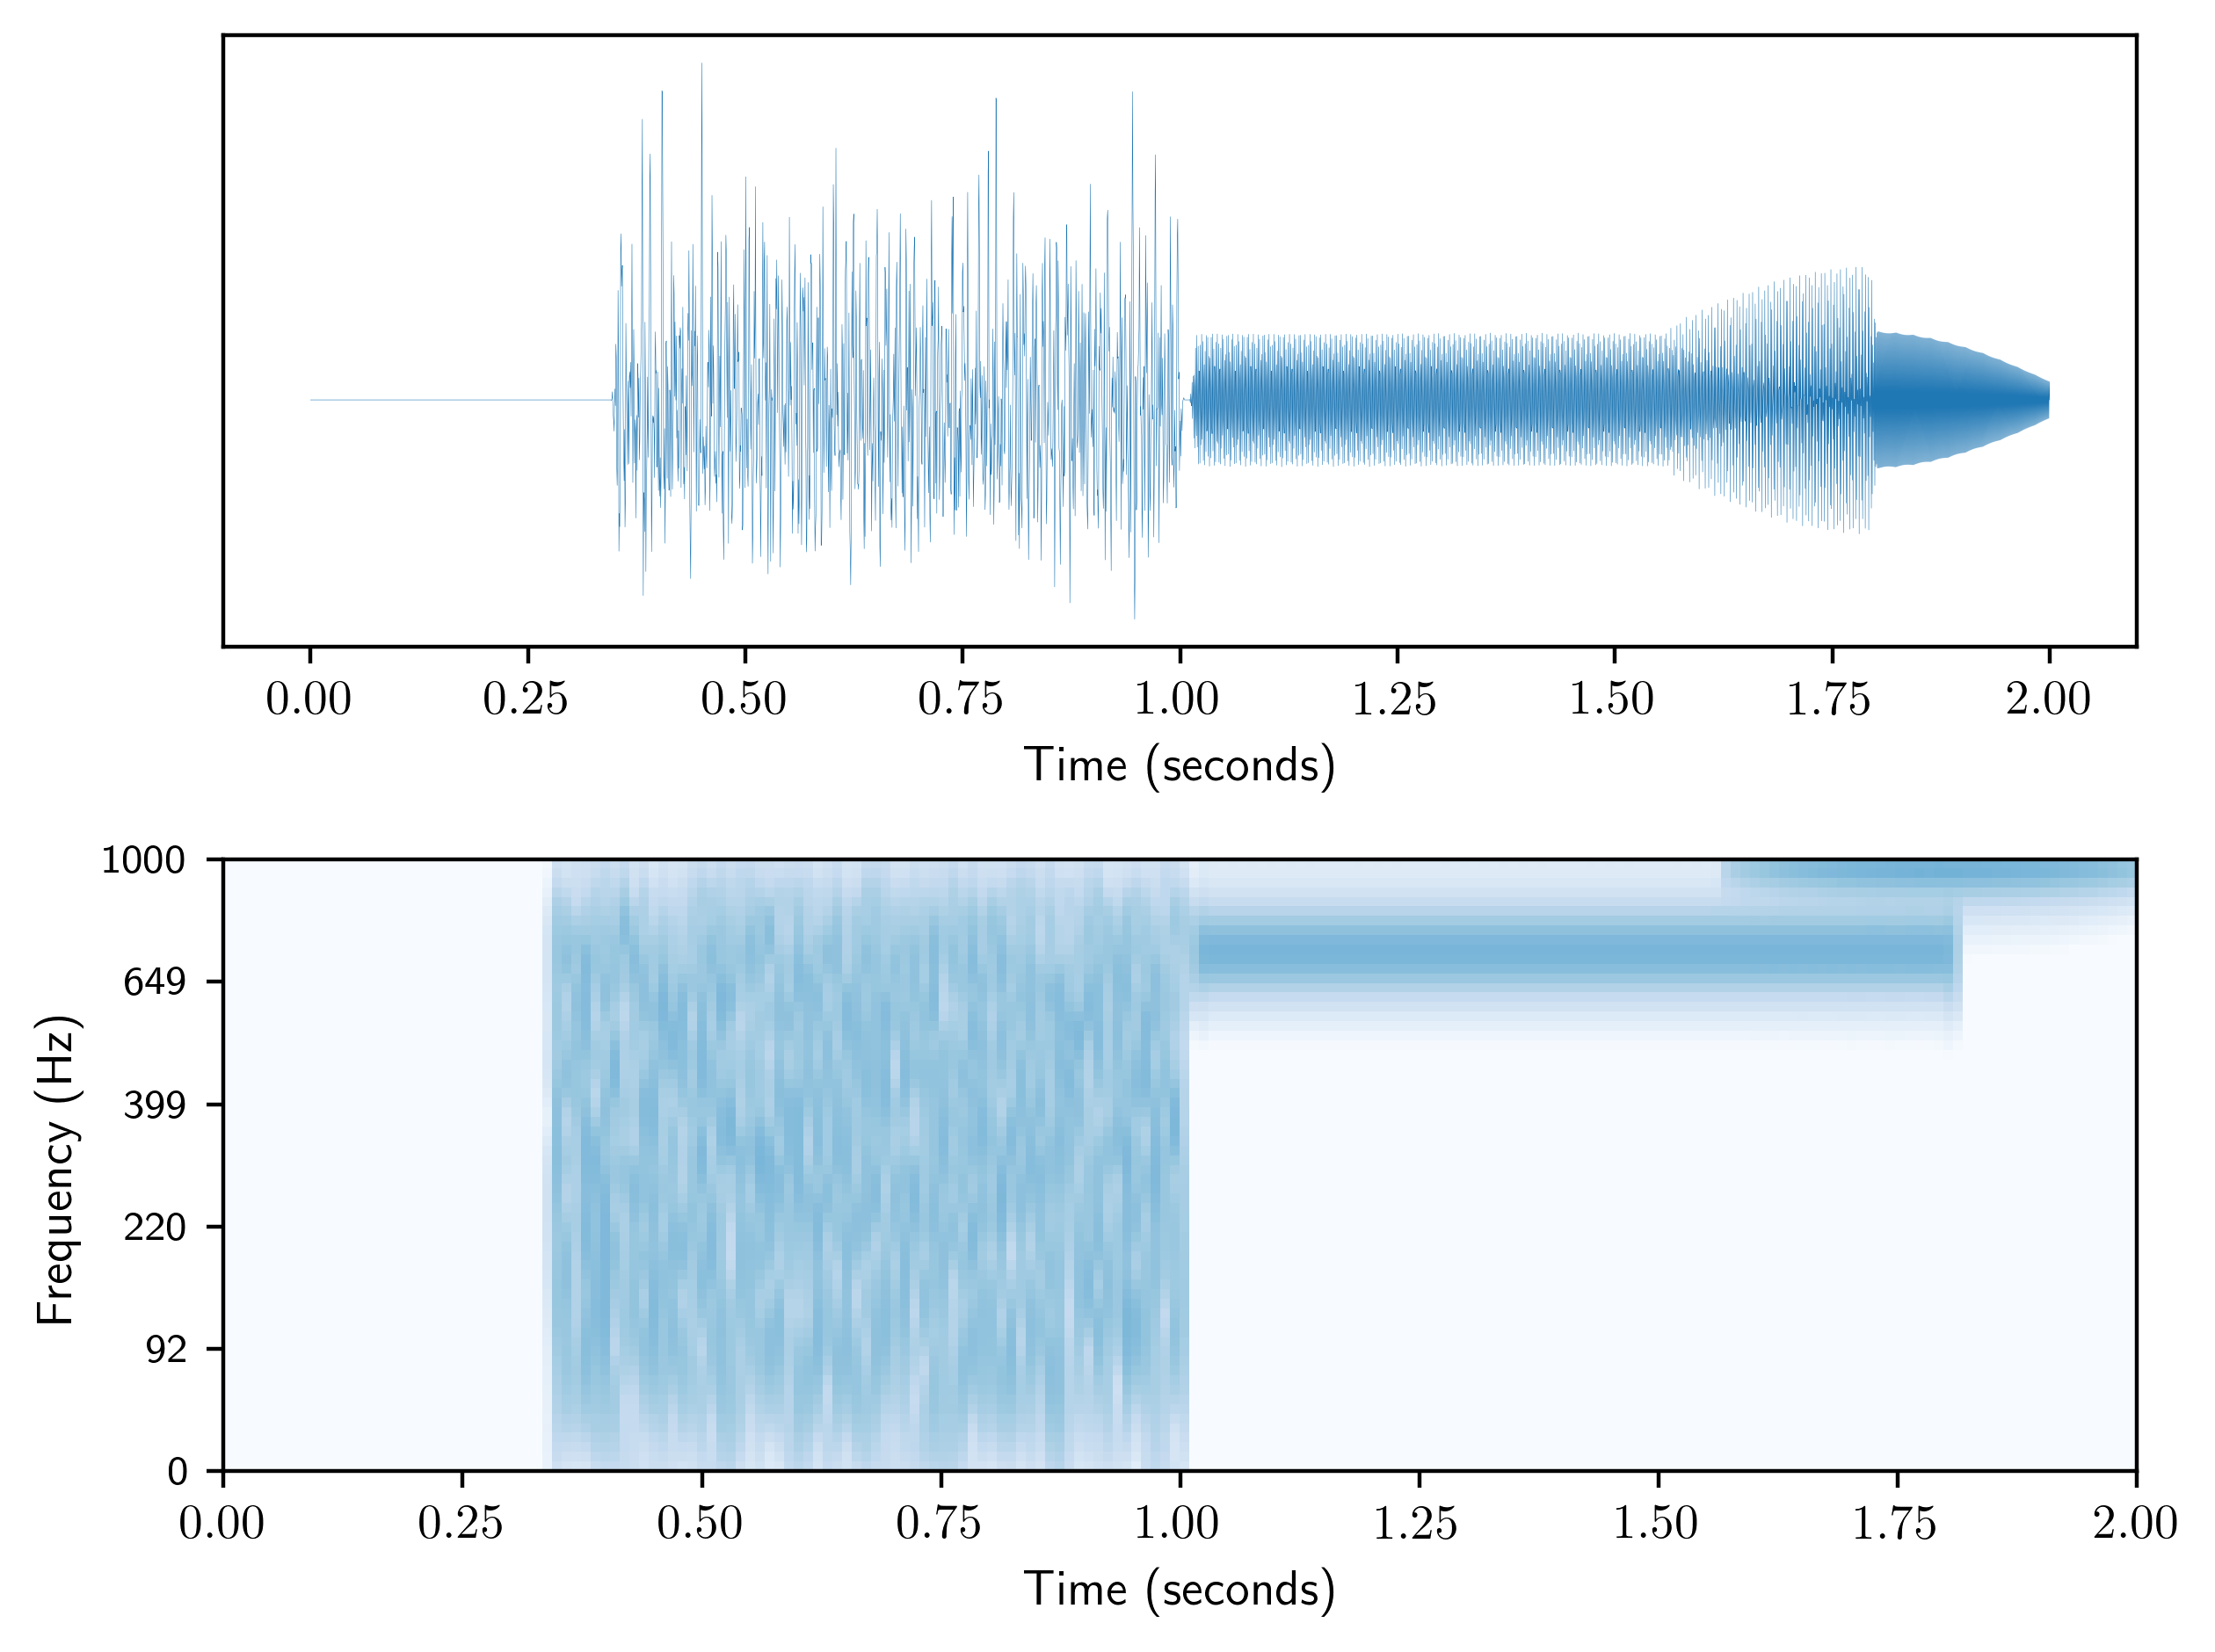

In [172]:
tr = simulate(generate_scene, args);
vis_and_write_wave(tr, "simulated_scene.wav")

Playback (works on Mac, maybe not other platforms):

In [160]:
; aplay simulated_scene.wav

Playing WAVE 'simulated_scene.wav' : Float 32 bit Little Endian, Rate 2000 Hz, Mono


# Inference

In [161]:
function do_inference(tr, iters)
  for i=1:iters
    if i % 100 == 0
        println("iter $i")
    end
    for j=1:tr[:n_tones]
        tr, = mh(tr, select(:waves => j))
        if tr[:waves => j => :is_noise]
          tr, = mh(tr, select(:waves => j => :amp))
        else
          tr, = mh(tr, select(:waves => j => :erb))
        end
        tr, = mh(tr, select(:waves => j => :onset))
        tr, = mh(tr, select(:waves => j => :duration))
    end
    tr, = mh(tr, select(:n_tones))
  end
  tr
end

do_inference (generic function with 1 method)

# Testing

Generate ground truth:

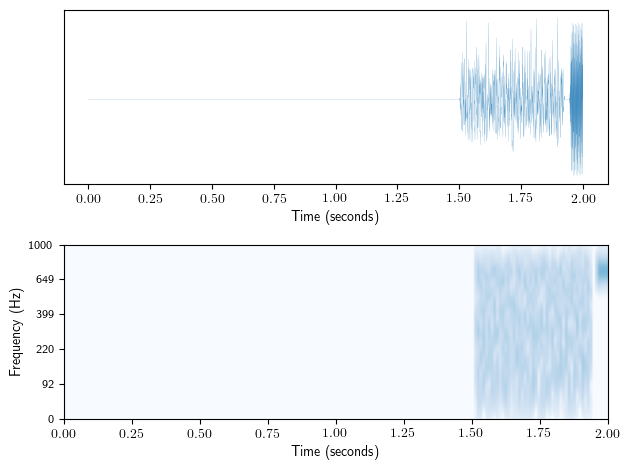

In [162]:
ground_truth = simulate(generate_scene, args);
vis_and_write_wave(ground_truth, "ground_truth.wav")

In [163]:
; aplay ground_truth.wav

Playing WAVE 'ground_truth.wav' : Float 32 bit Little Endian, Rate 2000 Hz, Mono


Generate trace with constraints:

In [25]:
inferred_trace, = generate(generate_scene, args, choicemap(:scene => ground_truth[:scene]));

Run inference:

In [26]:
inferred_trace = do_inference(inferred_trace, 100);
get_score(inferred_trace)

-6294.655187020011

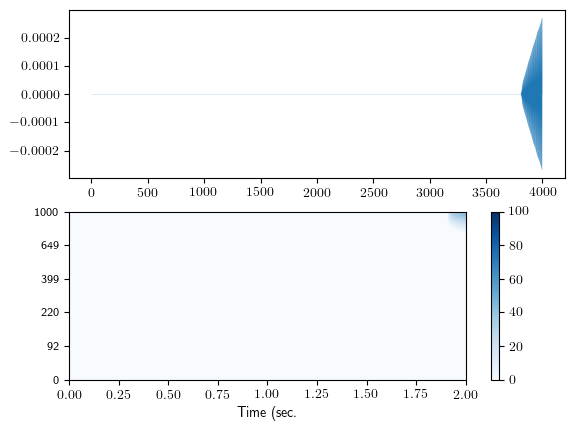

PyObject Text(0.5, 23.83700013837, 'Time (sec.')

In [27]:
vis_and_write_wave(inferred_trace, "inferred.wav")

In [28]:
; aplay ground_truth.wav

Playing WAVE 'ground_truth.wav' : Float 32 bit Little Endian, Rate 2000 Hz, Mono


In [29]:
observations = choicemap(:scene => tr[:scene])
inferred_tr, = generate(generate_scene, (2.0, wts, sr, steps, gtg_params), observations);

In [30]:
inferred_tr = do_inference(inferred_tr, 100);
get_score(inferred_tr)

-510542.59393334936

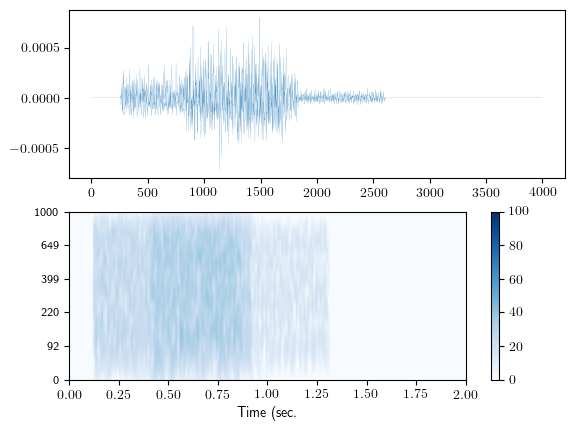

PyObject Text(0.5, 23.83700013837, 'Time (sec.')

In [31]:
vis_and_write_wave(inferred_tr, "inferred.wav")

In [32]:
; aplay inferred.wav

Playing WAVE 'inferred.wav' : Float 32 bit Little Endian, Rate 2000 Hz, Mono


# Auditory illusion setup

In [173]:
function plot_gtg(gtg, duration, audio_sr, vmin, vmax;colors="Blues",plot_colorbar=true)
    max_freq=audio_sr/2
    imshow(gtg, cmap=colors, origin="lower", extent=(0, duration, 0, max_freq),vmin=vmin, vmax=vmax, aspect="auto")
    locs, labels = yticks();
    lowlim = freq_to_ERB(1.)
    hilim = freq_to_ERB(max_freq)
    fs = Int.(floor.(ERB_to_freq(range(lowlim, stop=hilim, length=length(locs)))))
    setp(gca().set_yticklabels(fs), fontsize="small")
    if plot_colorbar
        plt.colorbar()
    end
    xlabel("Time (seconds)")
    ylabel("Frequency (Hz)")
end

function plot_gtg_unscaled(gtg, duration, max_freq;colors="Blues")
    imshow(gtg, cmap=colors, origin="lower", extent=(0, duration, 0, max_freq),aspect="auto")
    xlabel("Time (seconds)")
    ylabel("Frequency (Hz)")
    #plt.colorbar()
end



plot_gtg_unscaled (generic function with 1 method)

In [174]:
function plot_latents(trace, tspan)
    duration, _, sr, = get_args(tr)
    n = length(get_submaps_shallow(get_submap(get_choices(trace), :waves)))
    for (i, sound_choices) in get_submaps_shallow(get_submap(get_choices(trace), :waves))
        start = sound_choices[:onset]
        stop = sound_choices[:onset] + sound_choices[:duration]        
        if sound_choices[:is_noise]
        else
            freq = sound_choices[:erb]
        end
        wave = trace[:waves => i]
        gram, = gammatonegram(wave, wts, sr, gtg_params)
        subplot(n, 1, i)
        plot_gtg(gram, duration, sr, 0, 100, plot_colorbar=false)
        xlabel(nothing)
        ylabel(nothing)
        yticks([])
        xticks([])
        if tspan != nothing
            gca().set_xlim(tspan)
        end
        tight_layout()
    end
end

plot_latents (generic function with 2 methods)

In [175]:
function tones_with_noise(amp)
    cm = choicemap(:n_tones => 3,
              (:waves => 1 => :is_noise) => false,
              (:waves => 1 => :erb) => 10.0,
              (:waves => 1 => :onset) => 0.5,
              (:waves => 1 => :duration) => 0.3,
              (:waves => 2 => :is_noise) => false,
              (:waves => 2 => :erb) => 10.0,
              (:waves => 2 => :onset) => 1.1,
              (:waves => 2 => :duration) => 0.3,
              (:waves => 3 => :is_noise) => true,
              (:waves => 3 => :amp) => amp,
              (:waves => 3 => :onset) => 0.8,
              (:waves => 3 => :duration) => 0.3)
    tr, = generate(generate_scene, args, cm)
    return tr
end

tones_with_noise (generic function with 1 method)

In [176]:
trr = tones_with_noise(10.0);

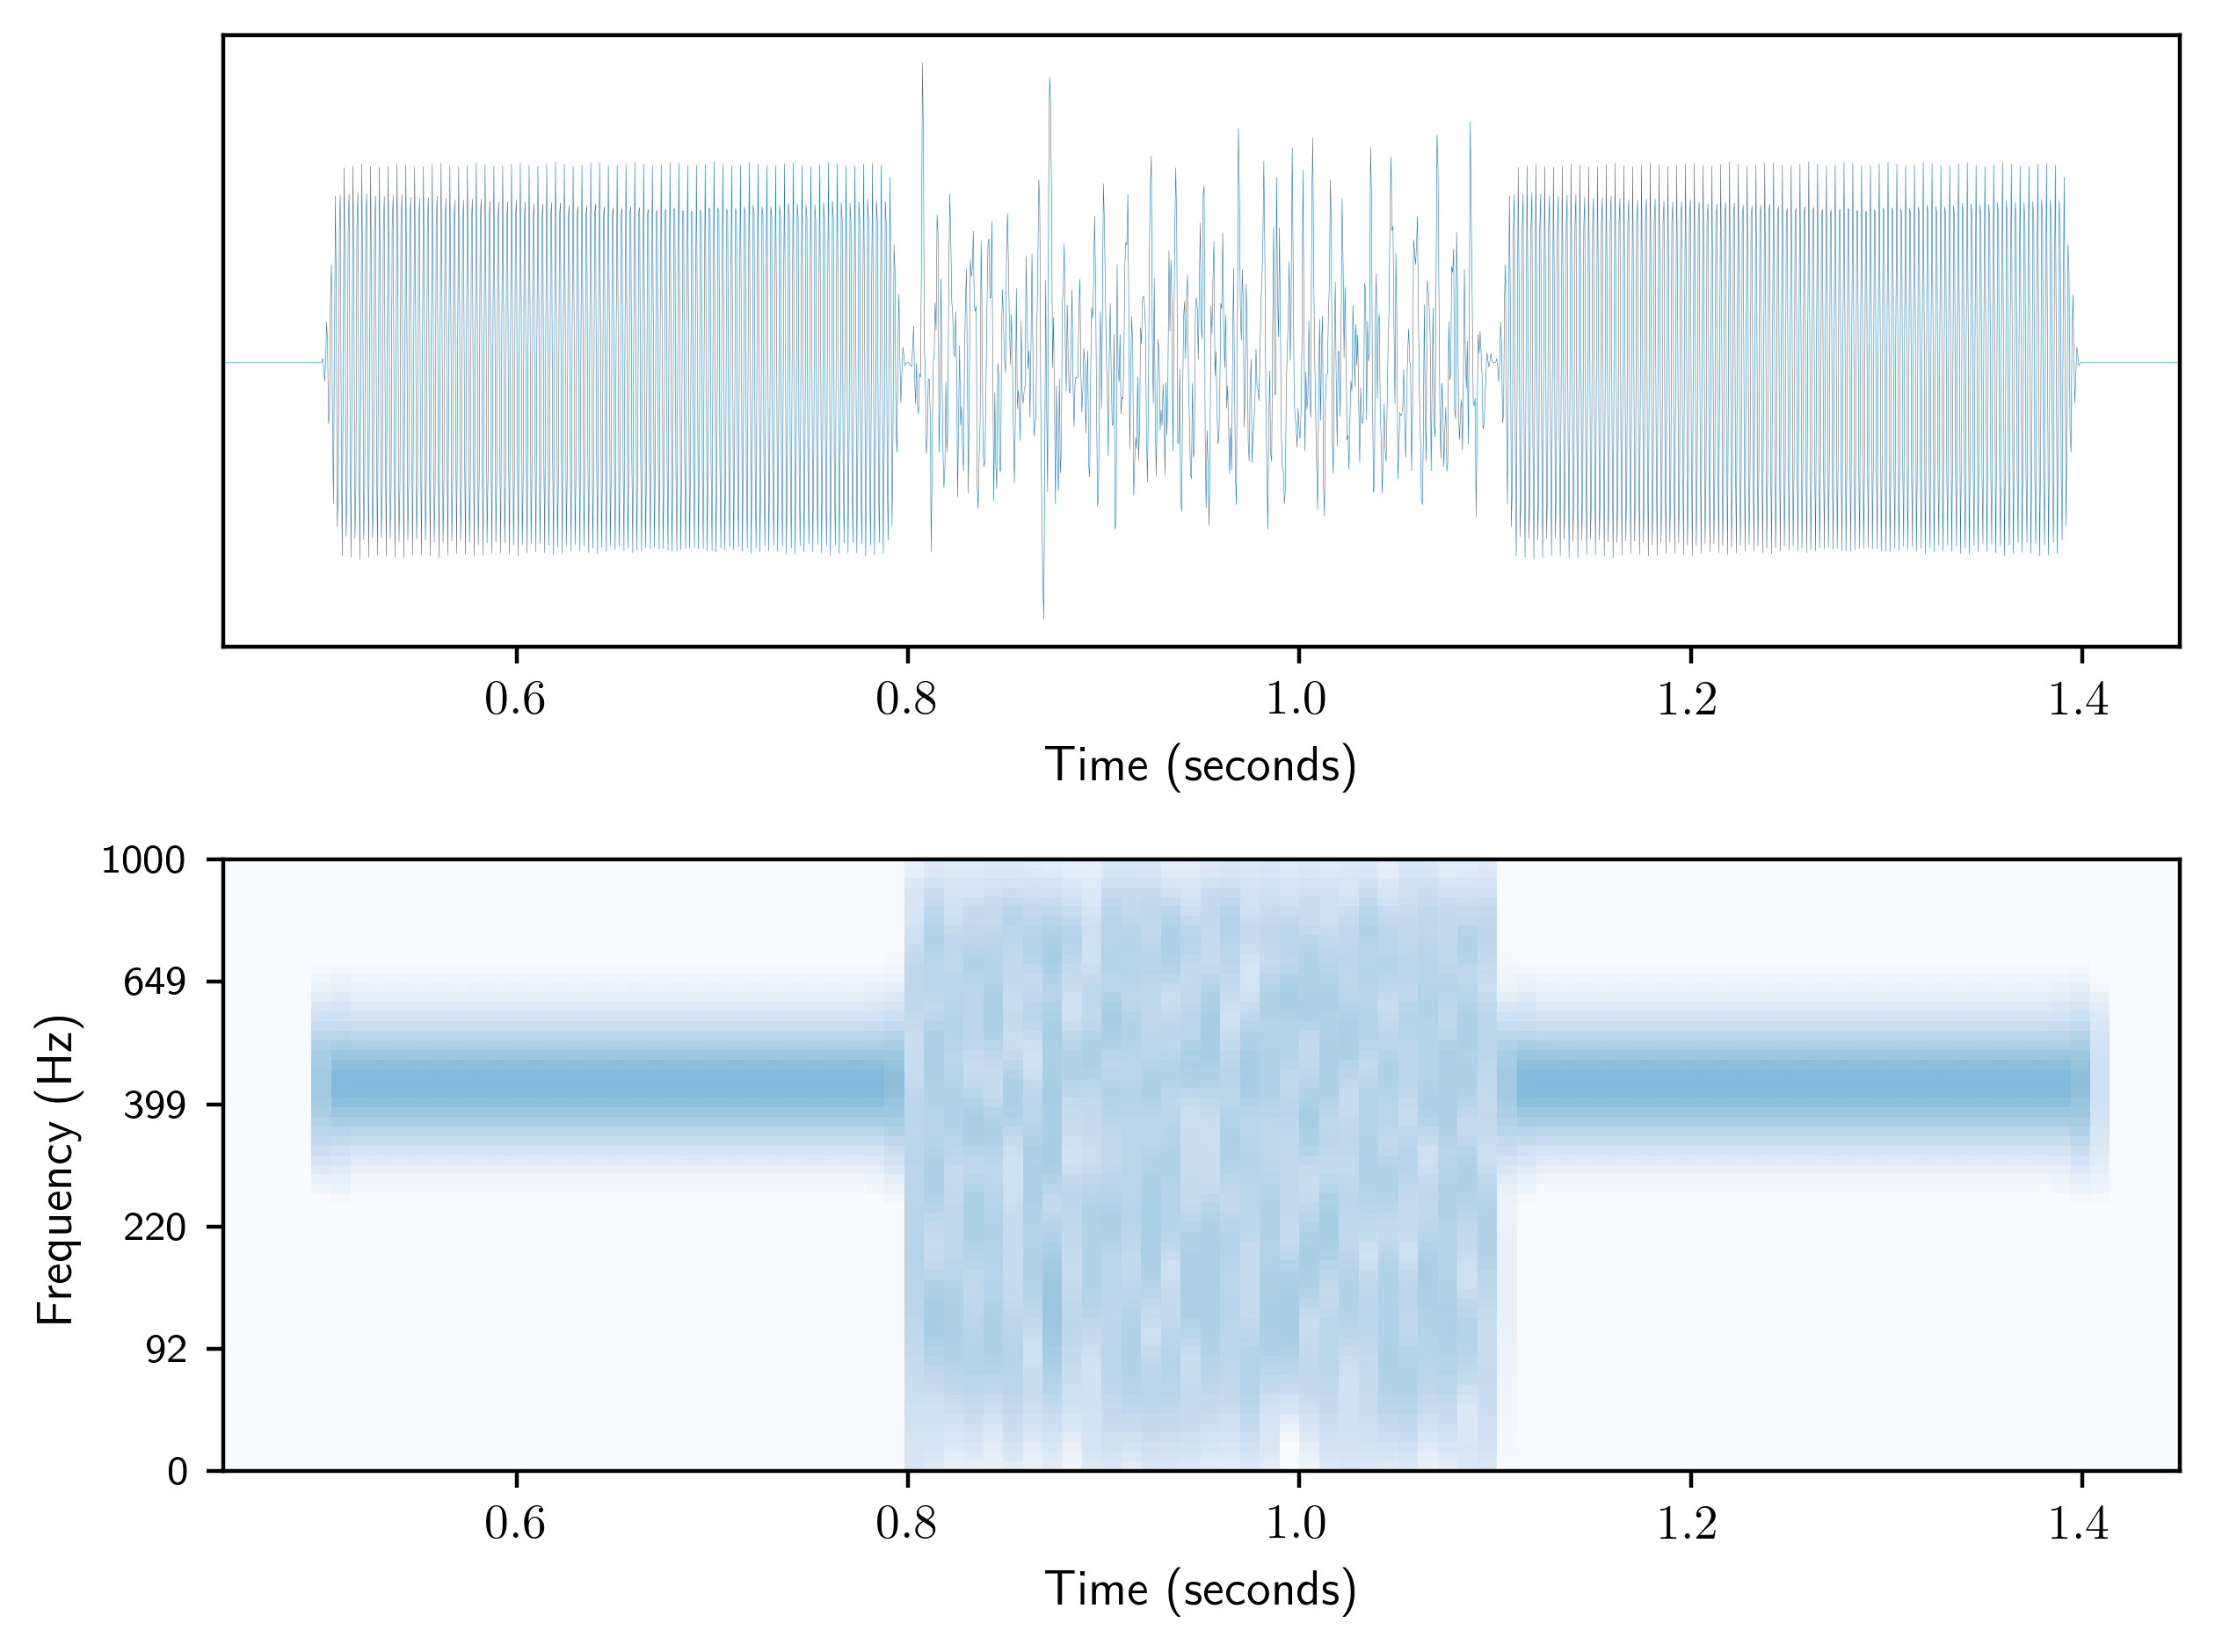

In [177]:
vis_and_write_wave(trr, "trr.wav", tspan=(0.45, 1.45))

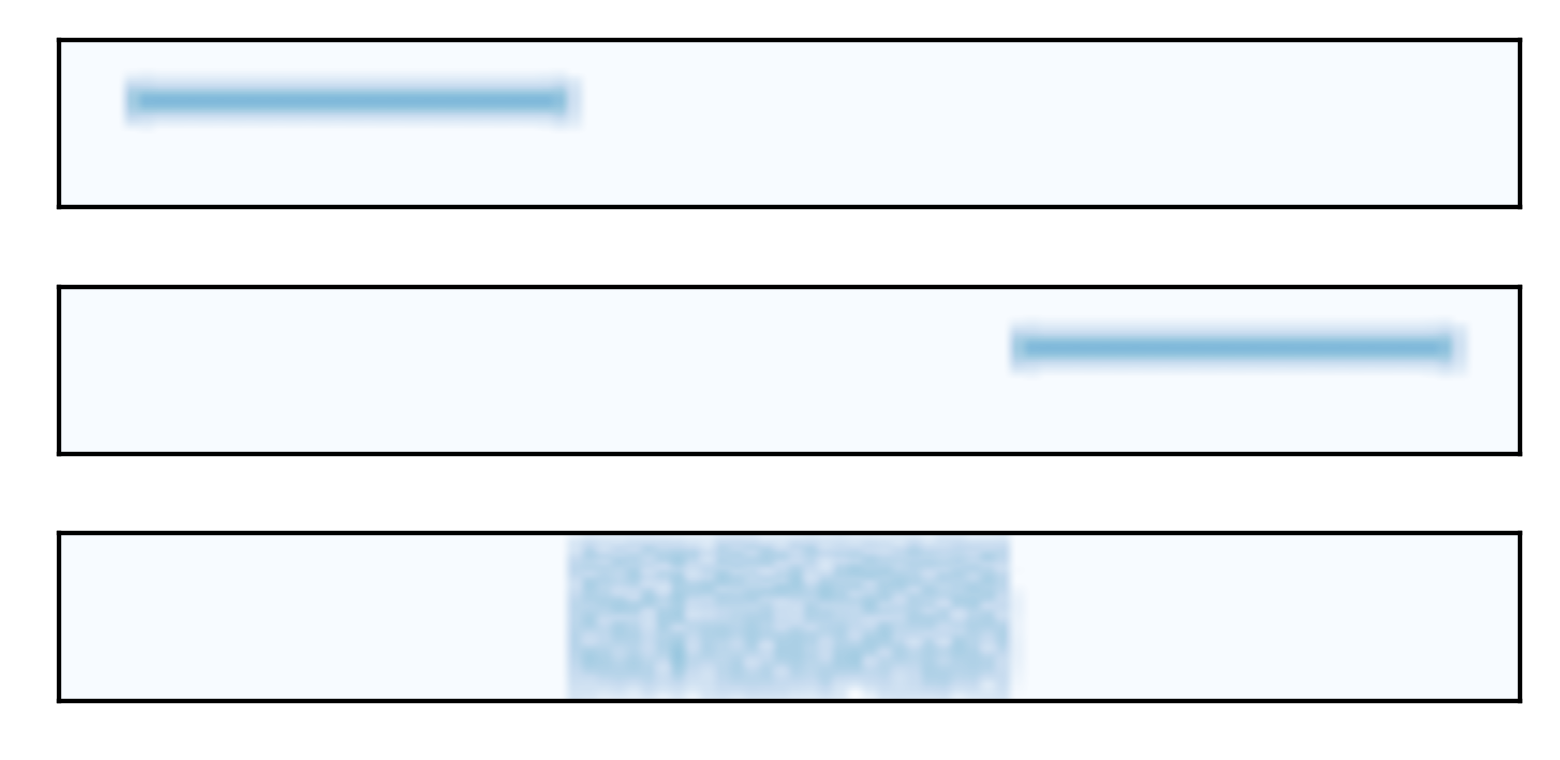

In [179]:
figure(figsize=(4, 2), dpi=400)
plot_latents(trr, (0.45, 1.45))
tight_layout()
savefig("trr.latents.png")

In [152]:
; aplay trr.wav

Playing WAVE 'trr.wav' : Float 32 bit Little Endian, Rate 2000 Hz, Mono


replicate 6
iter 100
iter 200
iter 300
iter 400
iter 500
replicate 7
iter 100
iter 200
iter 300
iter 400
iter 500
replicate 8
iter 100
iter 200
iter 300
iter 400
iter 500
replicate 9
iter 100
iter 200
iter 300
iter 400
iter 500
replicate 10
iter 100
iter 200
iter 300
iter 400


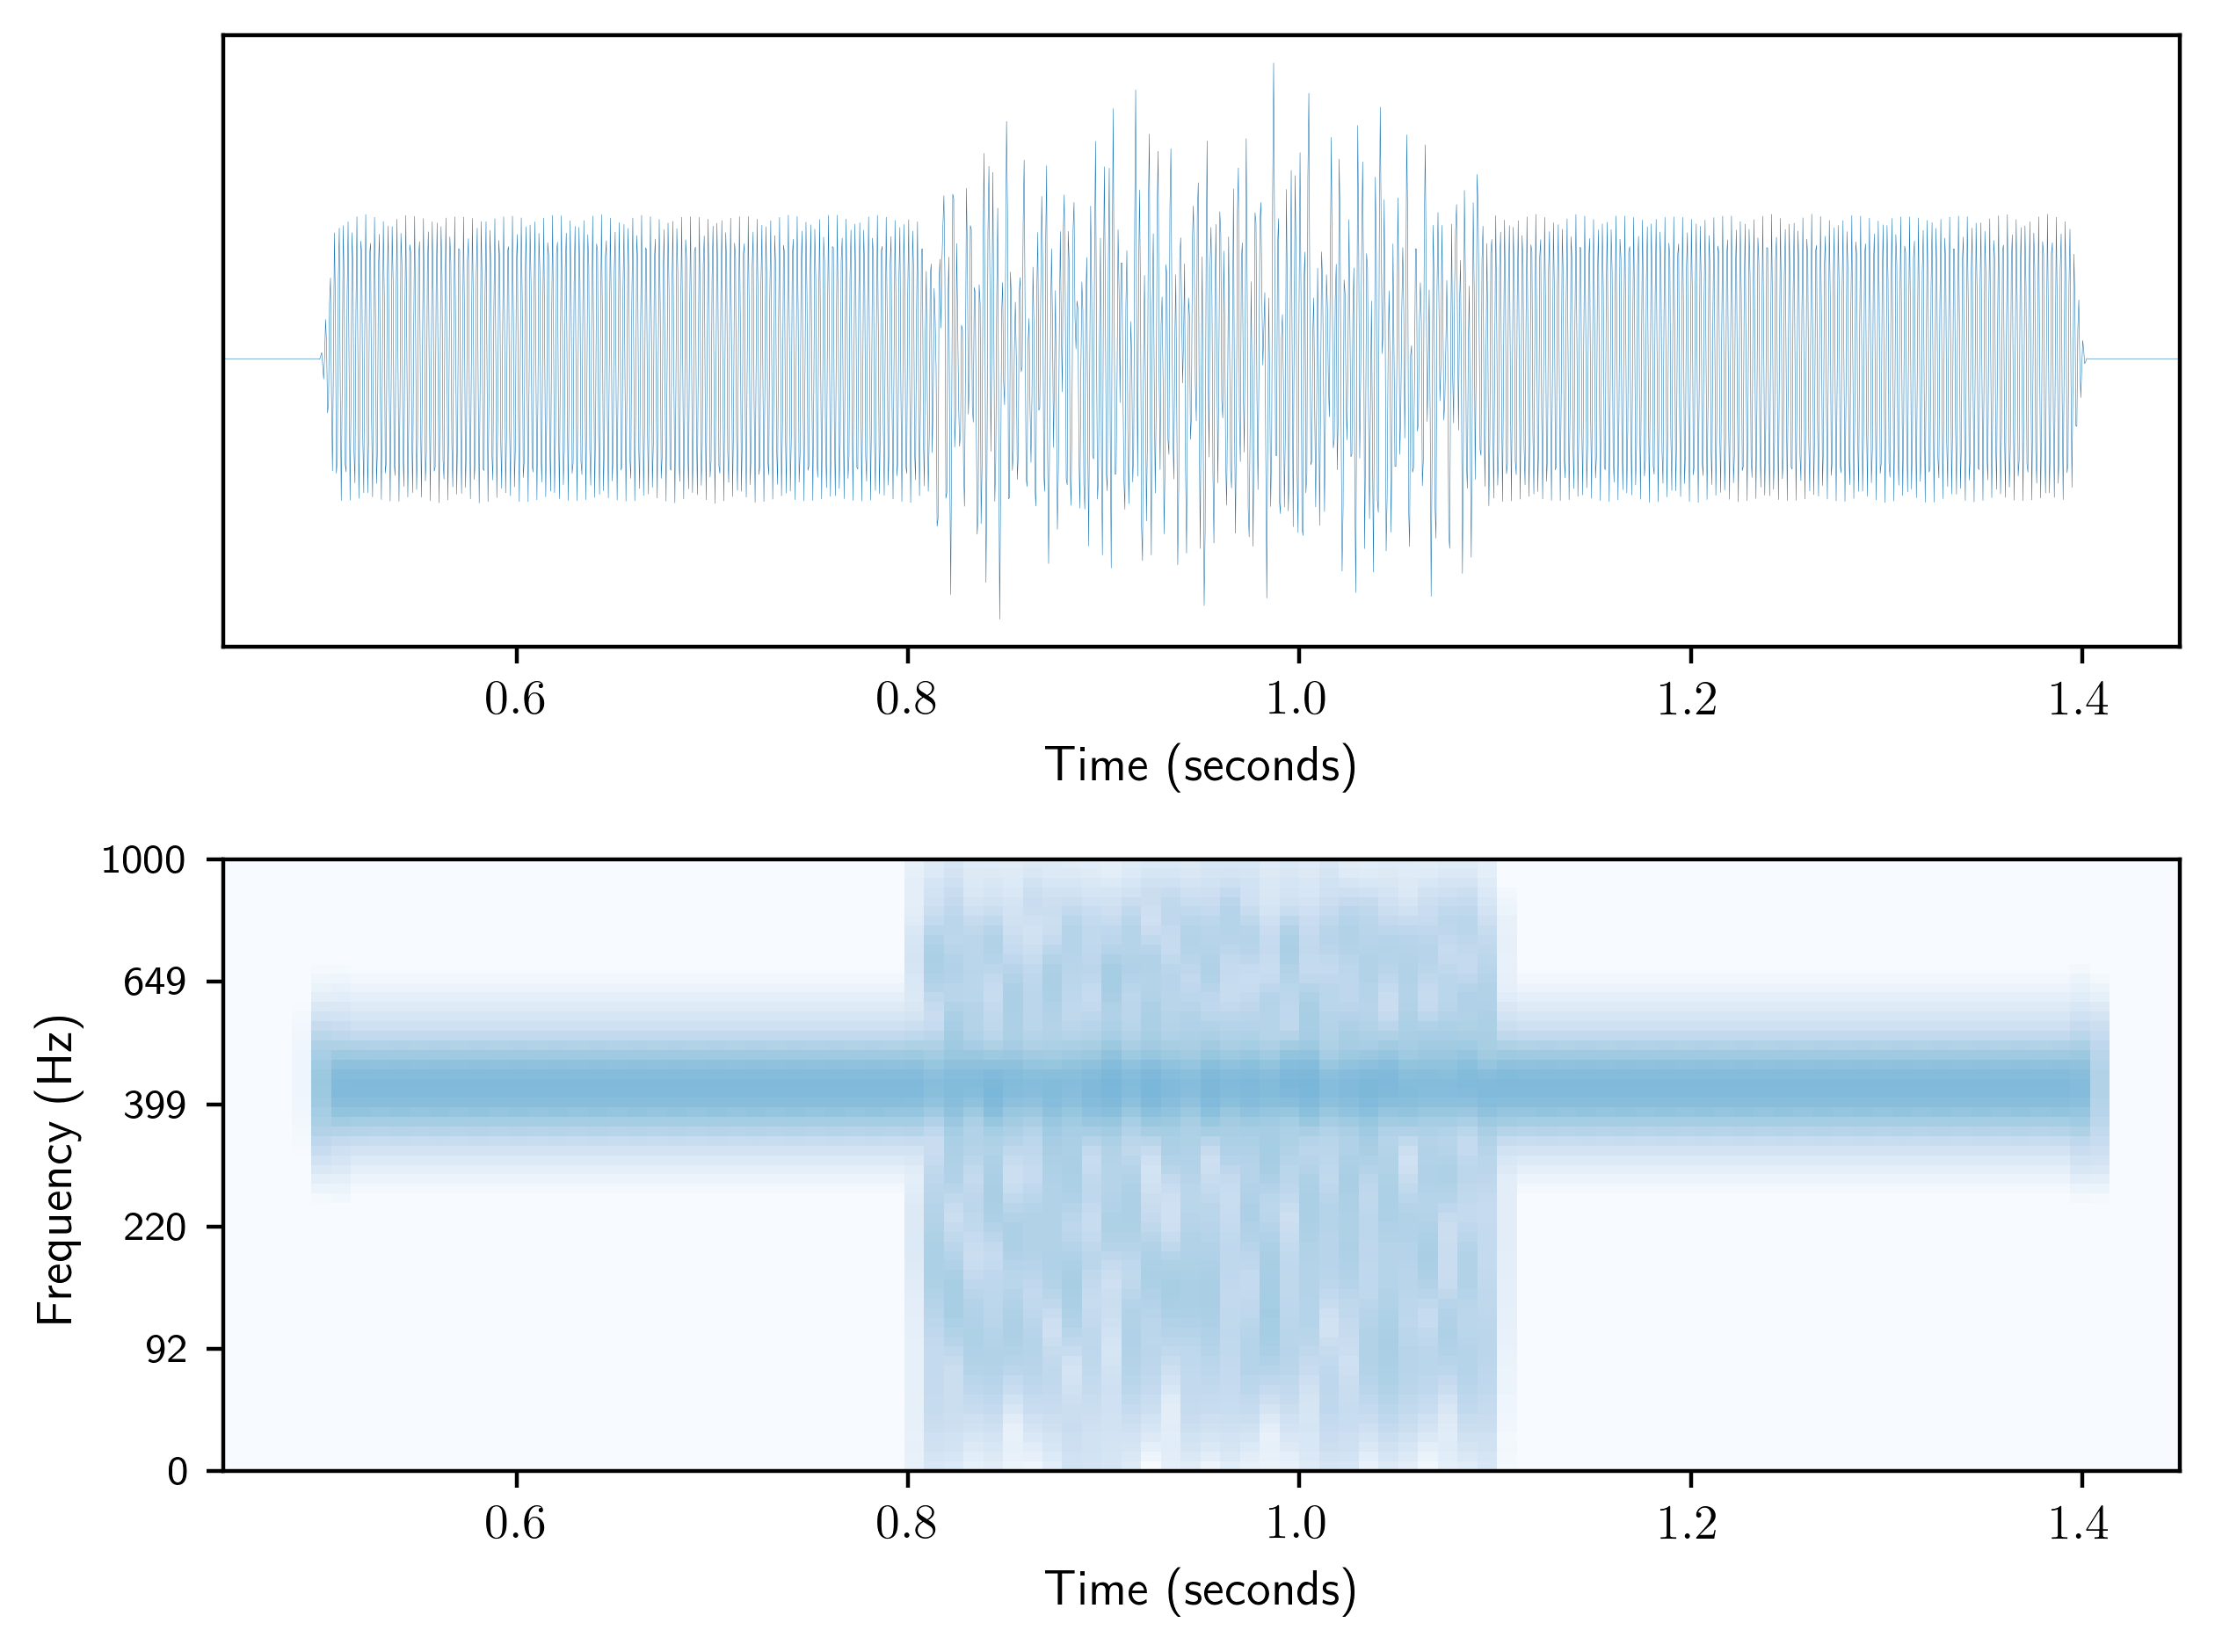

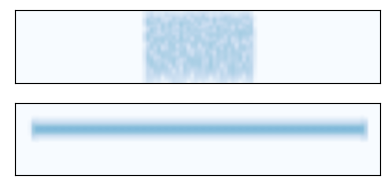

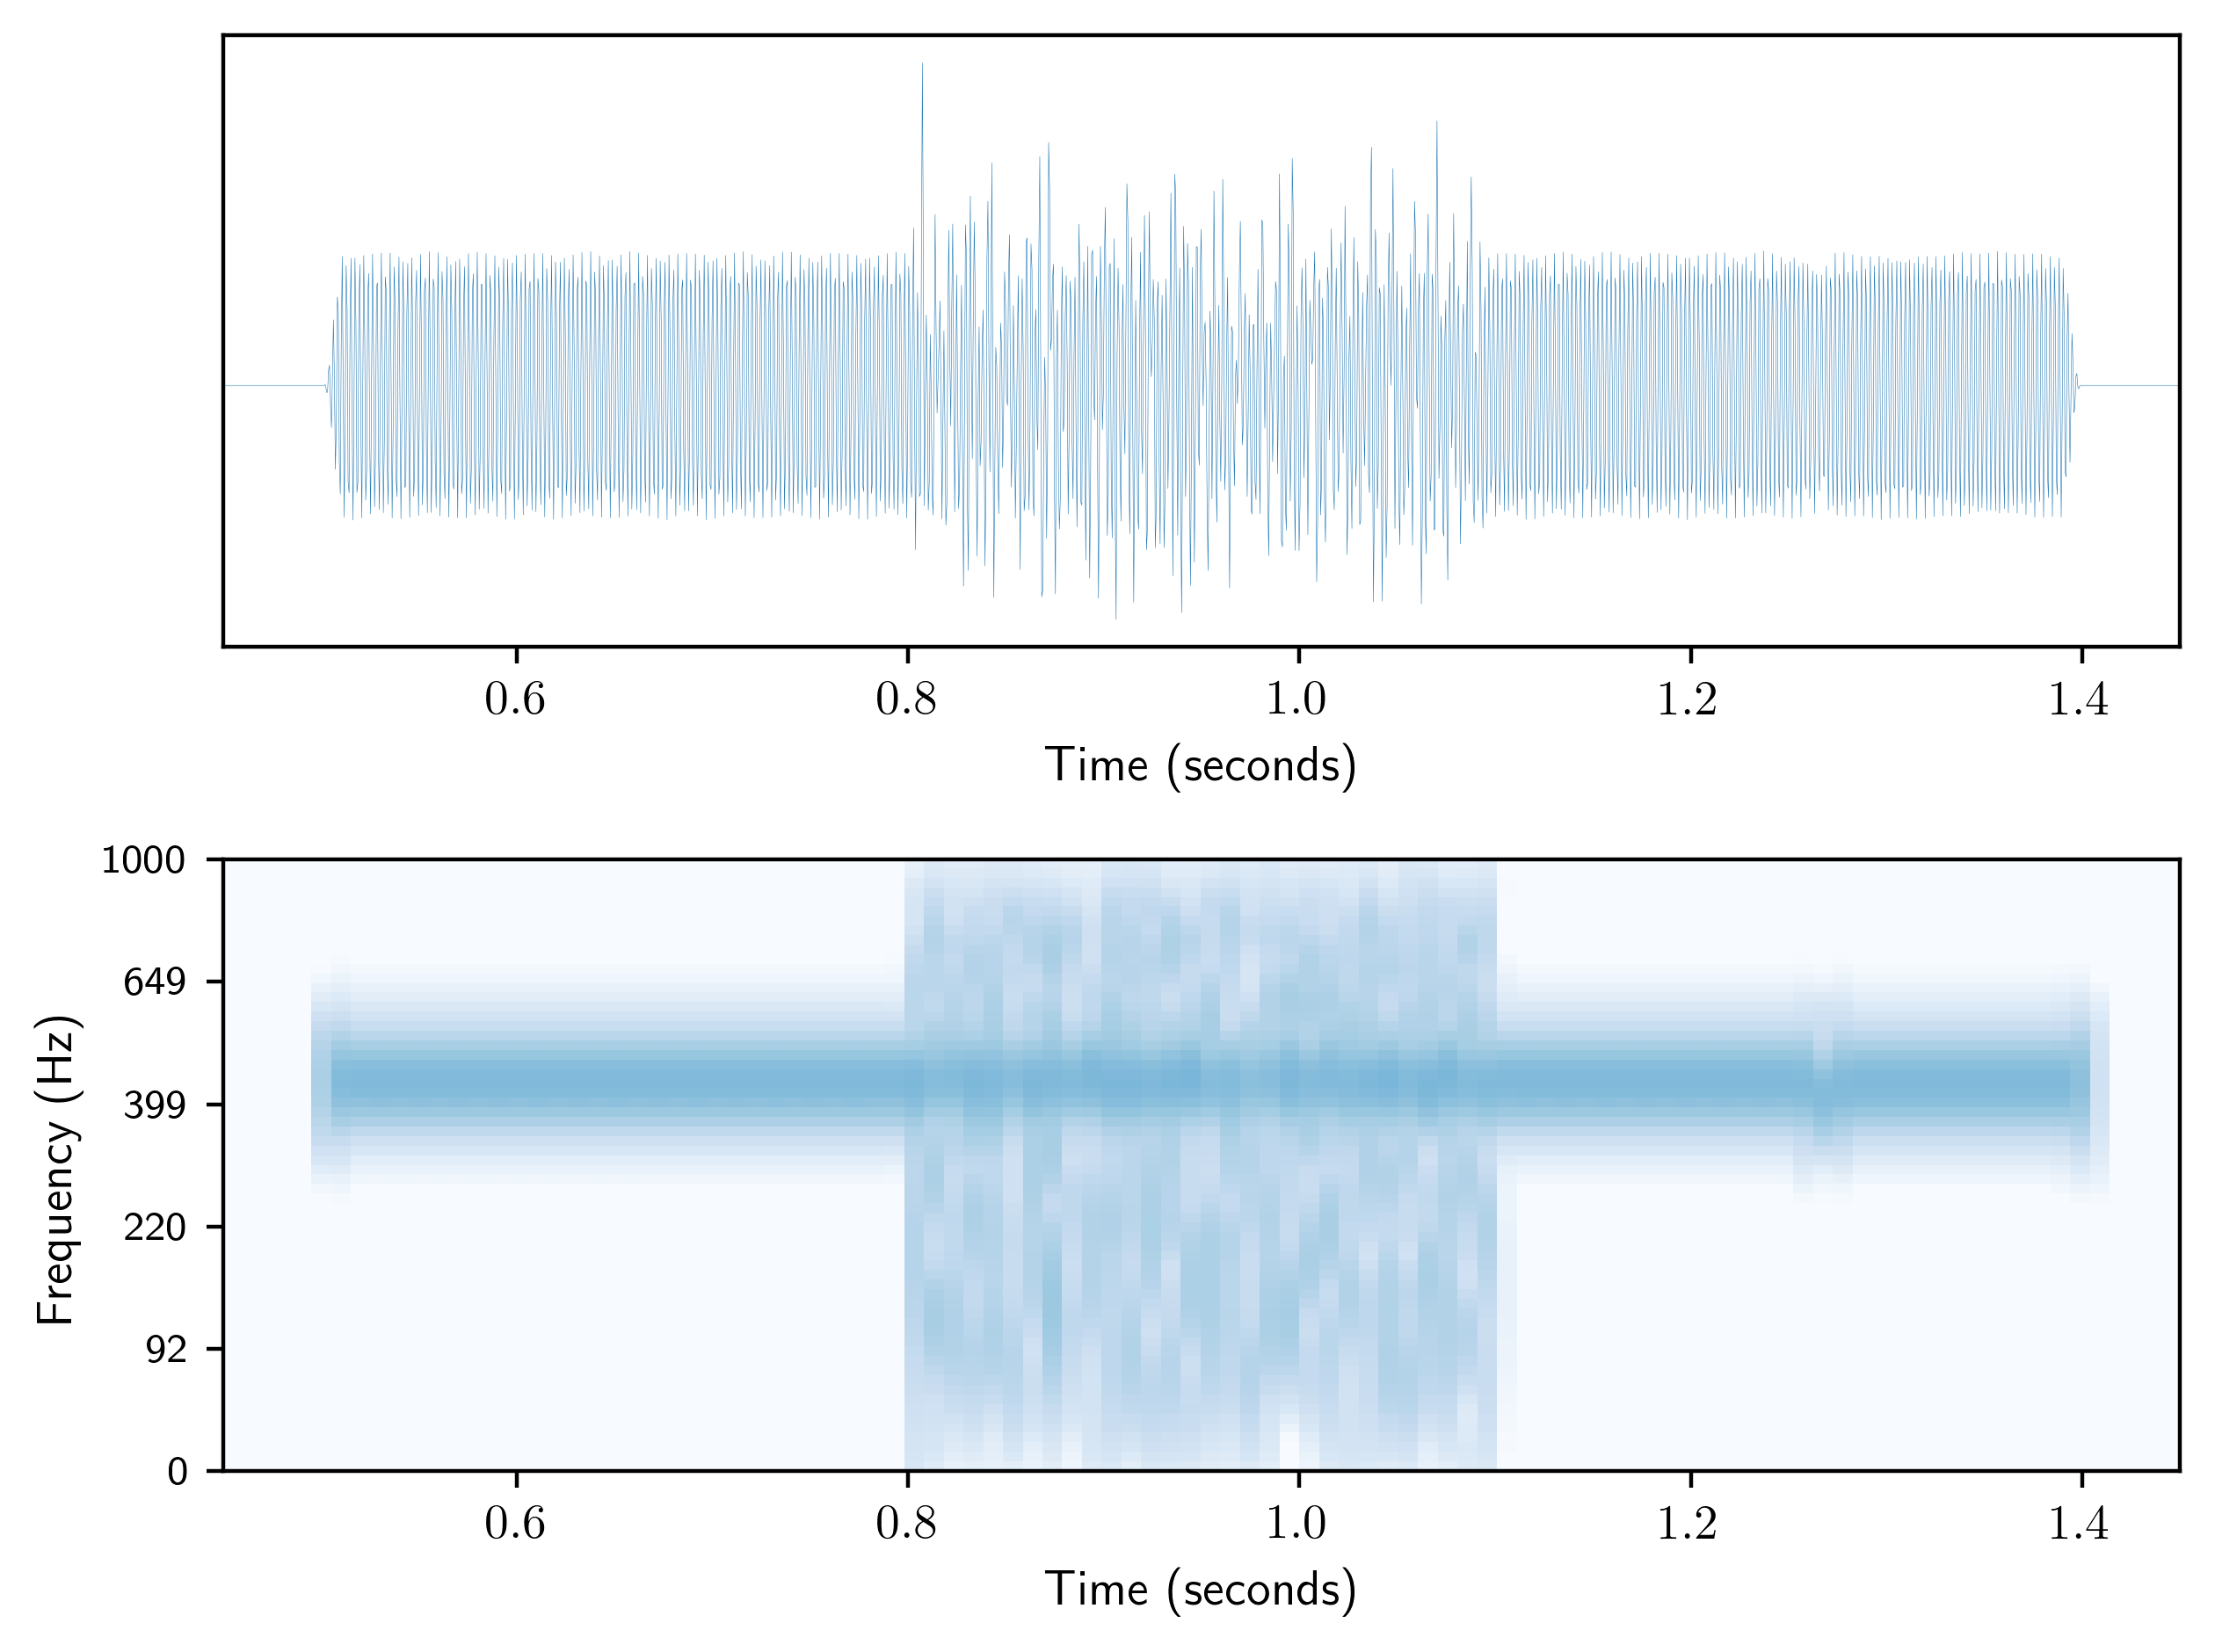

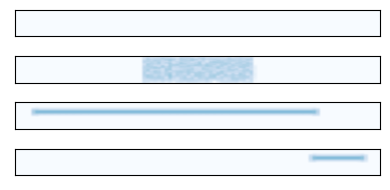

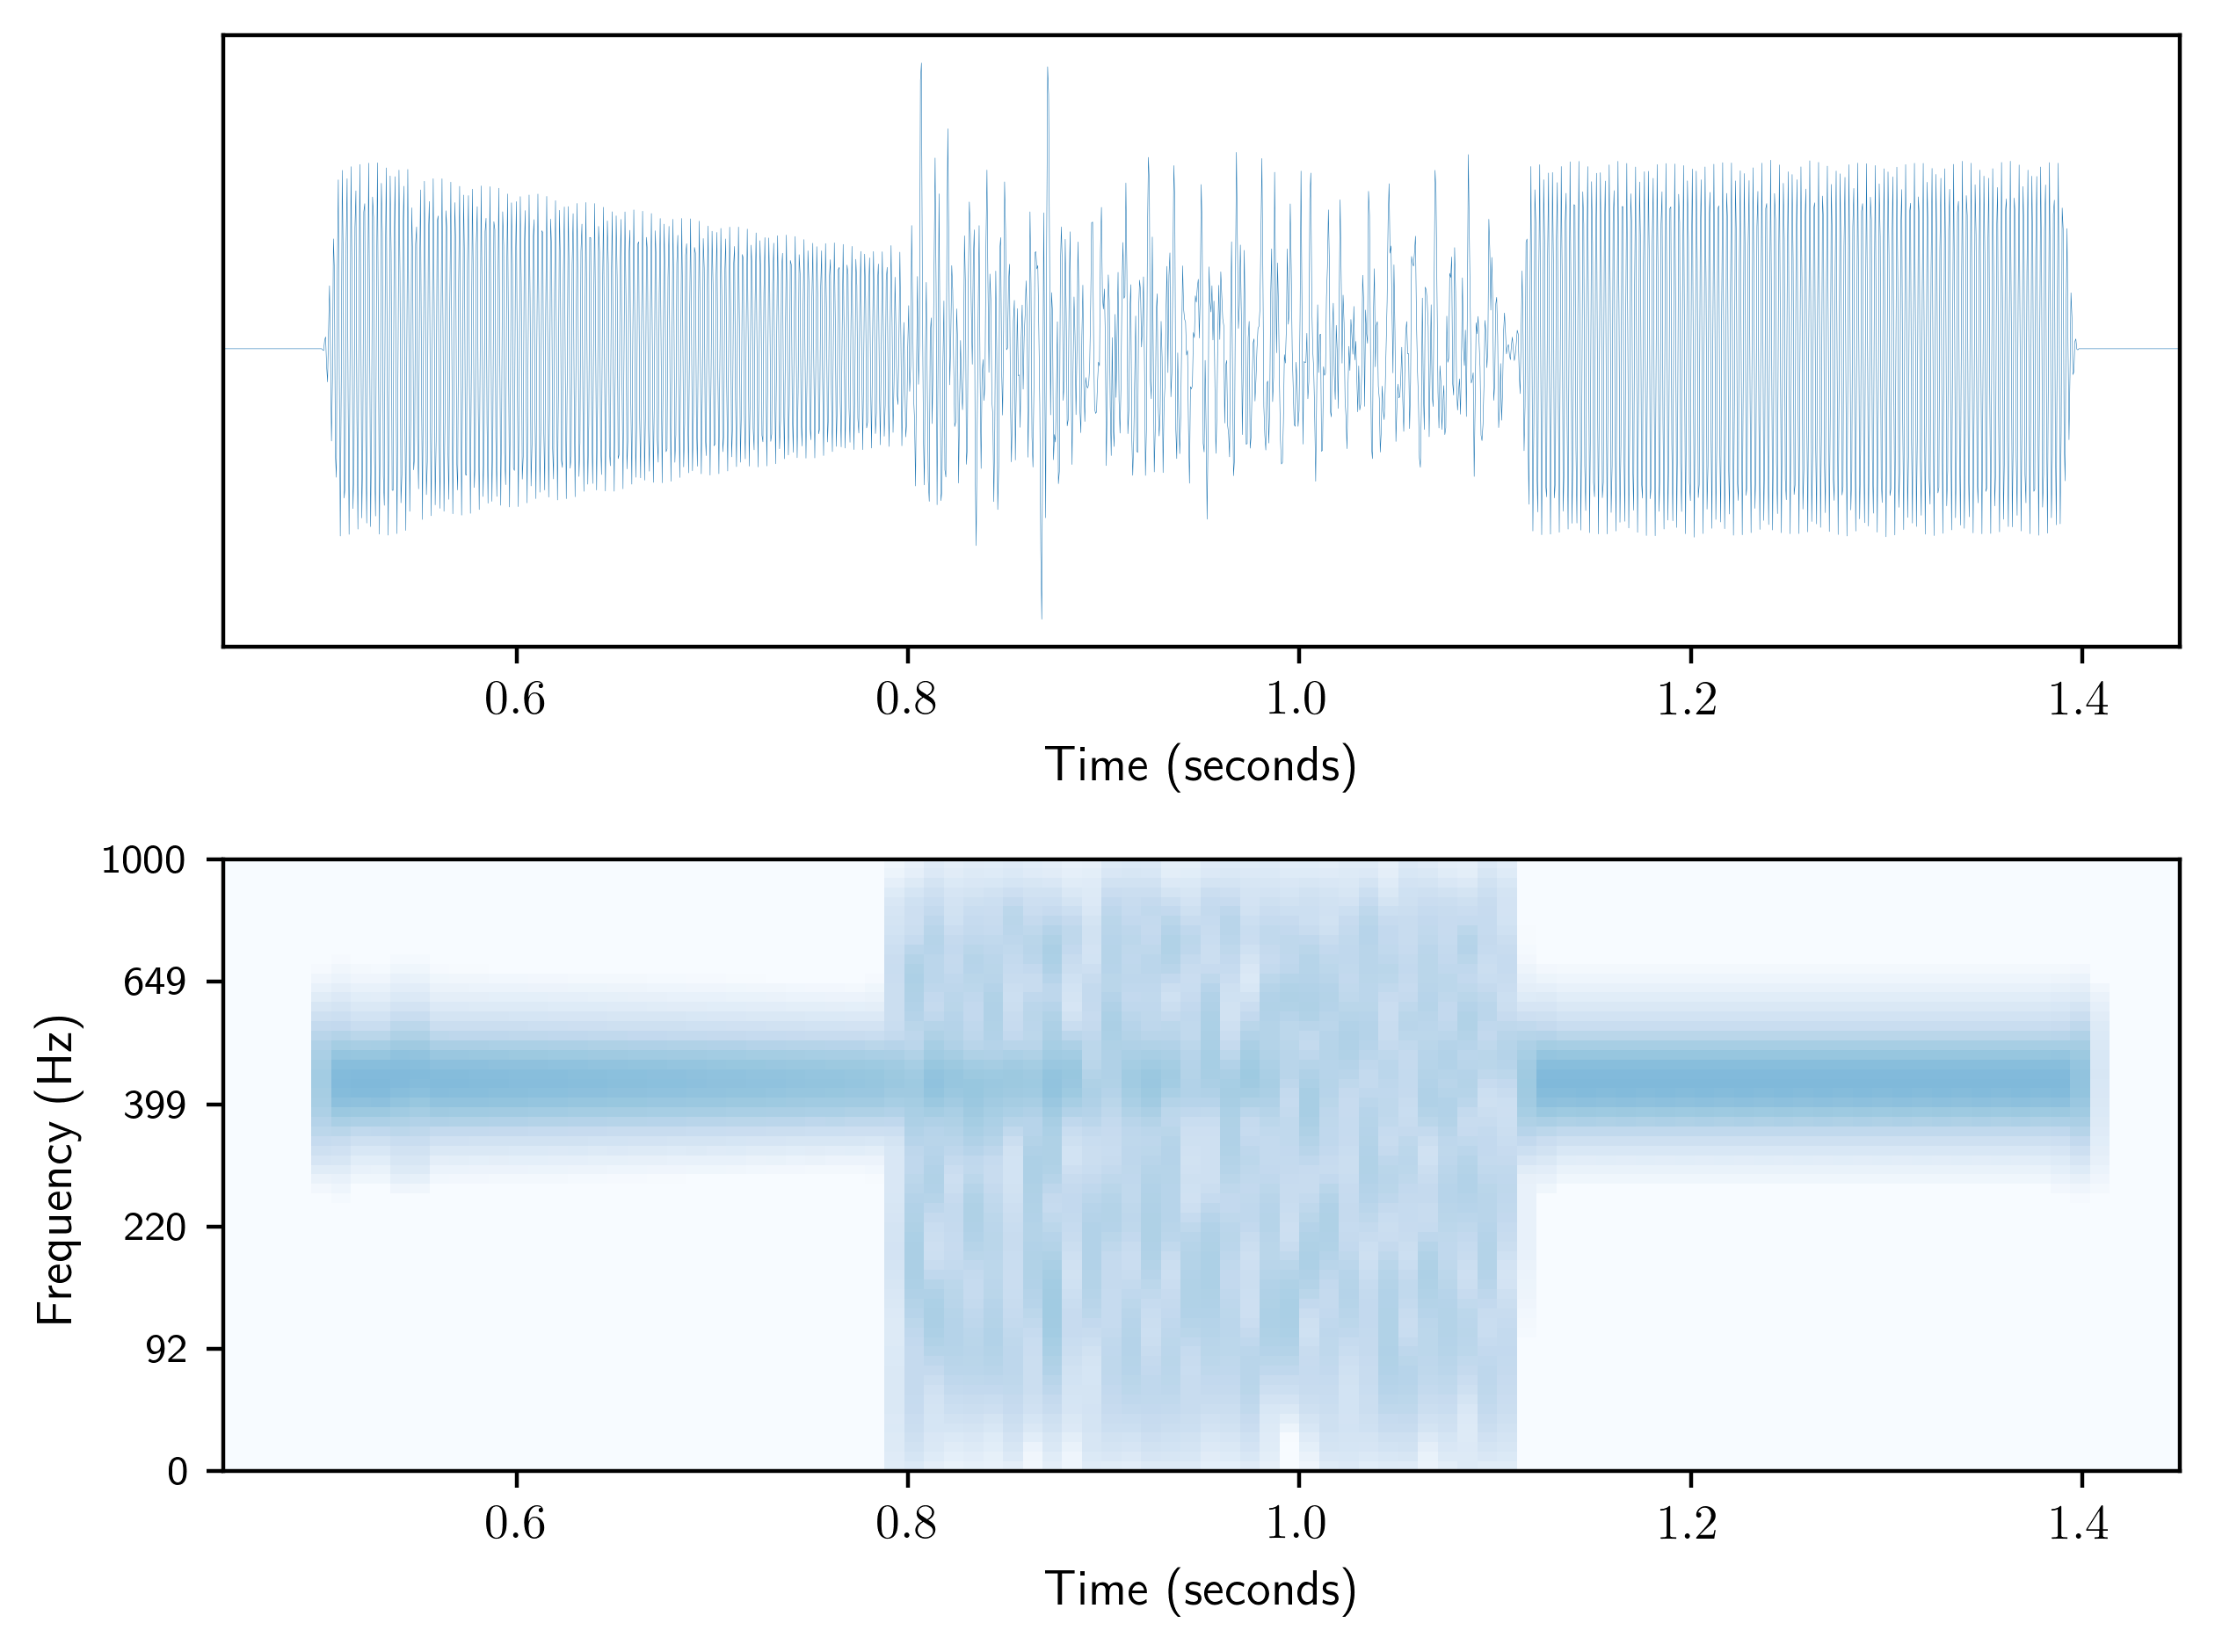

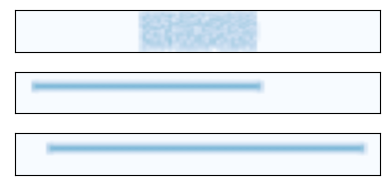

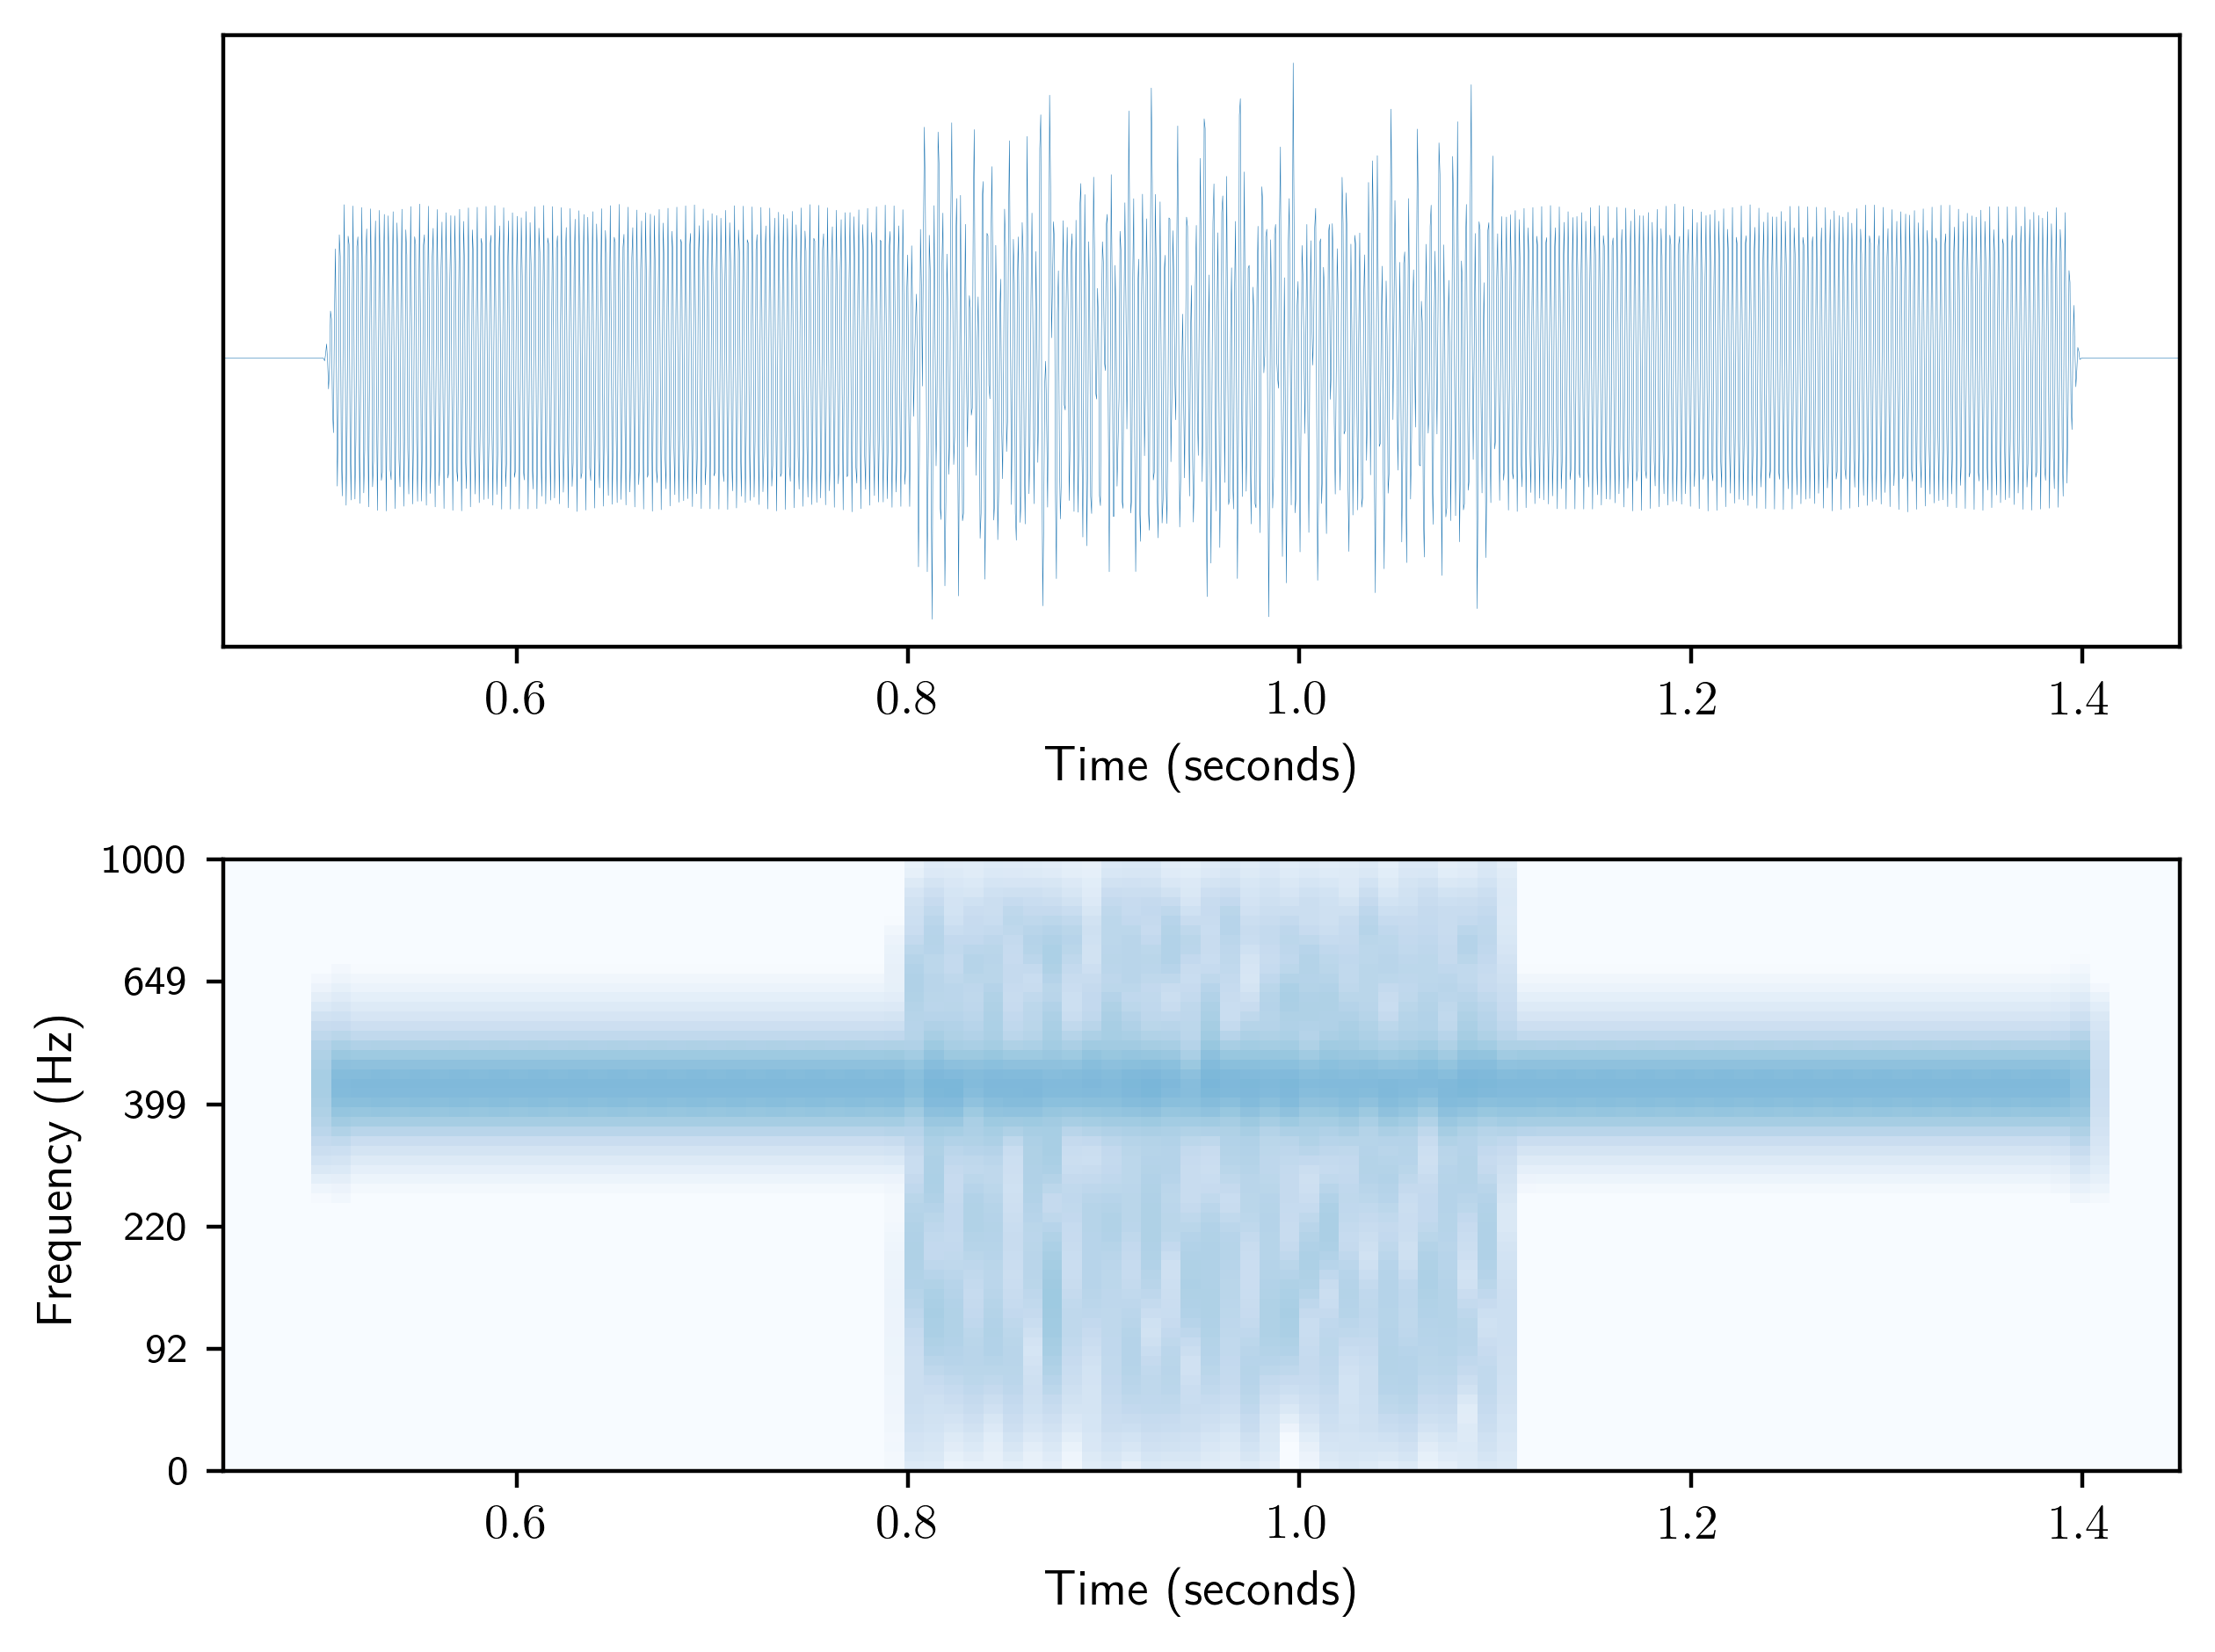

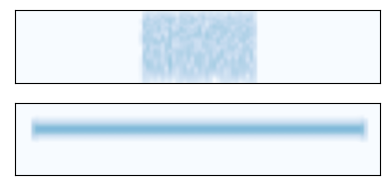

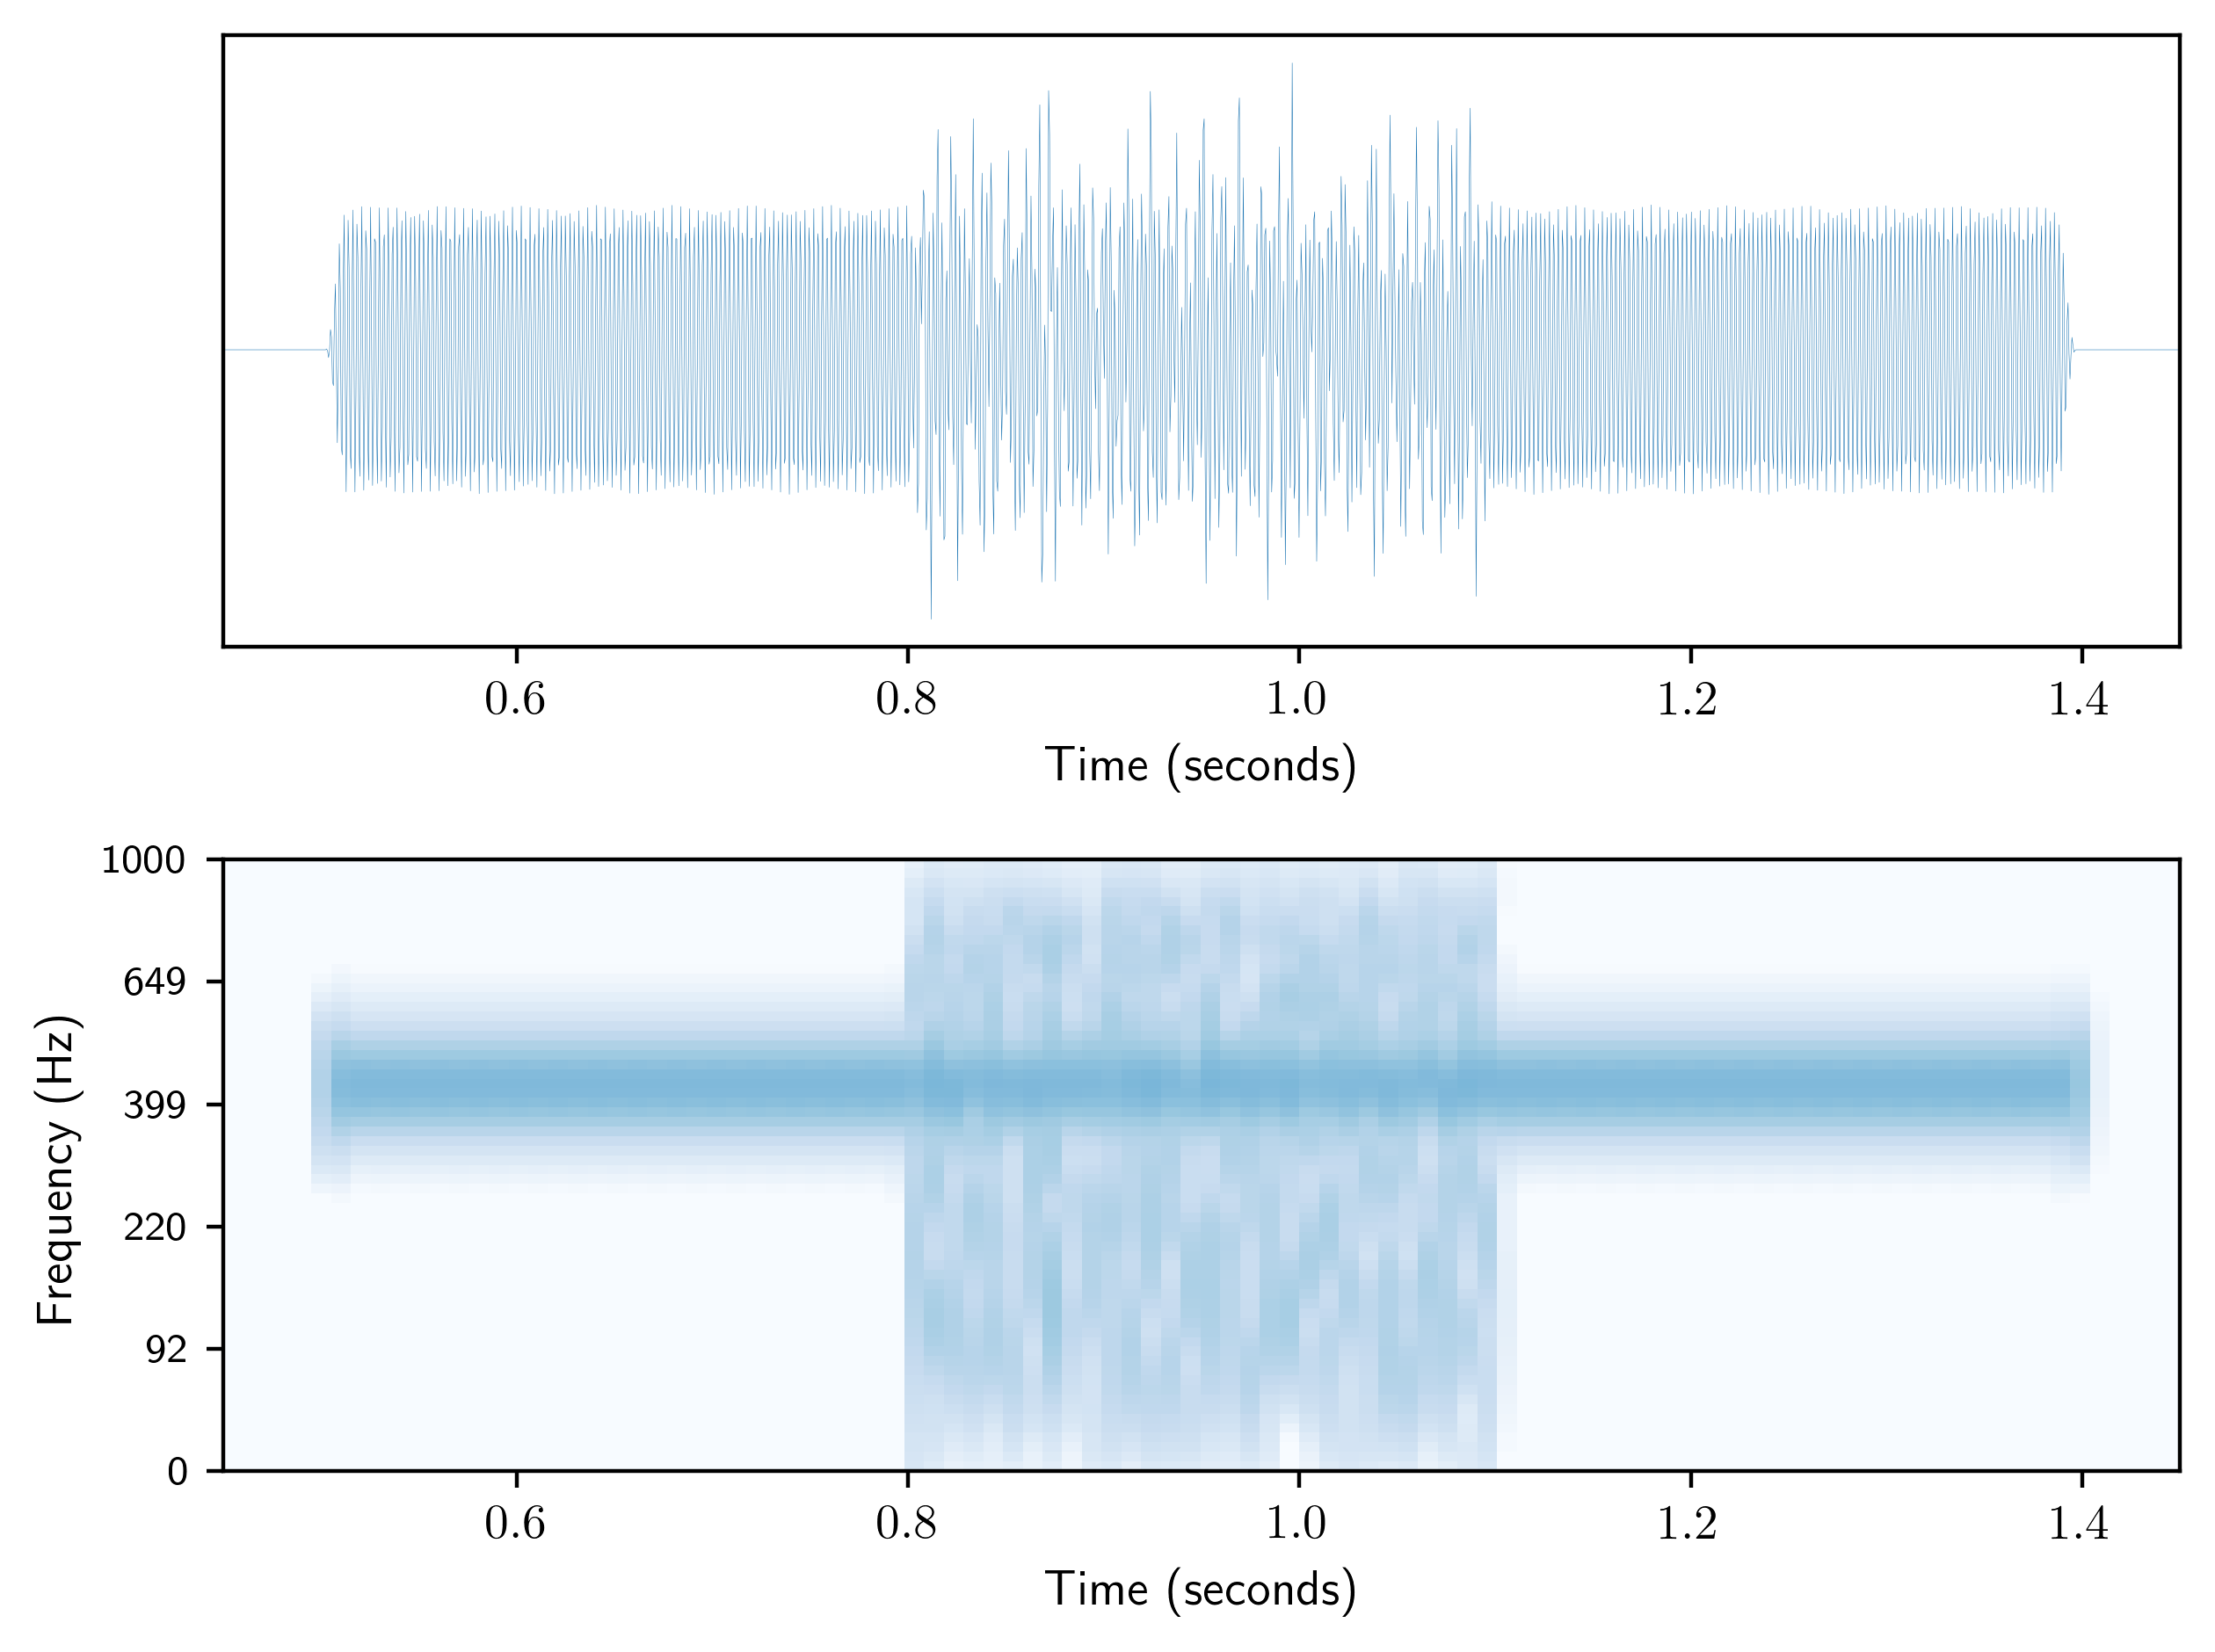

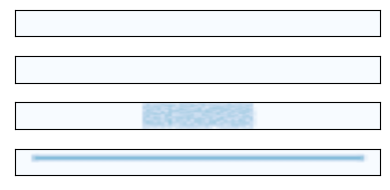

iter 500


In [181]:
import Random
Random.seed!(1)
for replicate in 6:10
    println("replicate $replicate")
    
    observations = choicemap(:scene => trr[:scene])
    inferred_tr, = generate(generate_scene, args, observations);
    
    inferred_tr = do_inference(inferred_tr, 500);
    get_score(inferred_tr)
    
    vis_and_write_wave(inferred_tr, "results/inferred.$replicate.wav", tspan=(0.45, 1.45))
    get_submap(get_choices(inferred_tr), :waves)
    
    figure(figsize=(4, 2))
    plot_latents(inferred_tr, (0.45, 1.45))
    tight_layout()
    savefig("results/inferred.$replicate.latents.pdf")
    
end

In [111]:
; aplay inferred.wav

Playing WAVE 'inferred.wav' : Float 32 bit Little Endian, Rate 2000 Hz, Mono
